## Sandbox for Implementing RetinaNet

Practice training runs on complex deep networks and experiment with object detection pipeline. Includes implementation of Feature Pyramid Networks, and RetinaNet. 

## General Approach

1. Download HeLa Binary Segmentation
- Build and train simple UpDownNet (no cross connections, but with upsampling)
- Build and train FPN (with simple outputs)
- Download COCO
- Build and train RetinaNet (with final detection subnets)

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *

## HeLa Cells

In [3]:
path = Path('/home/sudosharma/projects/data/hela')
path.ls()

[PosixPath('/home/sudosharma/projects/data/hela/02'),
 PosixPath('/home/sudosharma/projects/data/hela/models'),
 PosixPath('/home/sudosharma/projects/data/hela/02_GT'),
 PosixPath('/home/sudosharma/projects/data/hela/01'),
 PosixPath('/home/sudosharma/projects/data/hela/01_GT')]

In [4]:
class BinaryImageSegment(ImageSegment):
    @property
    def data(self):
        return self.px.float()

class BinarySegmentationLabelList(SegmentationLabelList):
    """Convert multi-instance label to background vs. cell binary segmentation."""
    def open(self, fn):
        mask = open_image(fn, div=False, convert_mode='L', cls=BinaryImageSegment)
        mask.px = (mask.px.sigmoid()>0.5).float()
        return mask
    
    def reconstruct(self, t): return BinaryImageSegment(t)

In [5]:
def get_img_lbls(path, seq):
    """Obtain the corresponding label for each image that actually has a segmented counterpart."""
    lbl = [l.name[-7:-4] for l in (path/f'0{seq}_GT'/'SEG').ls()]
    img = [i.name for i in (path/f'0{seq}').ls() if i.name[-7:-4] in lbl]
    return img

def get_data(path=path, sz=512, bs=1):
    """Create data loader with different batch sizes and size of image."""
    ifiles = get_img_lbls(path, 1) + get_img_lbls(path, 2)
    get_y_fn_base = lambda path, o: path/f'0{o.stem[0]}_GT'/'SEG'/f'{o.stem[0]}man_seg{o.stem[-3:]}{o.suffix}'
    get_y_fn = partial(get_y_fn_base, path)
    return (SegmentationItemList
            .from_folder(path)
            .filter_by_folder(include=['01', '02'])
            .filter_by_func(lambda fname: fname.name in ifiles)
            .split_by_rand_pct(0.1)
            .label_from_func(get_y_fn, label_cls=BinarySegmentationLabelList, classes=np.array(['back', 'cell']))
            .transform(get_transforms(flip_vert=True, max_warp=0.5), tfm_y=True, size=sz)
            .databunch(bs=bs))

def get_weights(data):
    """Obtain weights to balance class frequencies."""
    data_balance = (torch.stack([f[1].data.sum()for f in data.train_ds])
                    .float()/(512*512)).sum()/len(data.train_ds)
    return torch.stack([data_balance, (1-data_balance)])

In [6]:
data = get_data(bs=8)
weights = get_weights(data)
weights

tensor([0.4554, 0.5446])

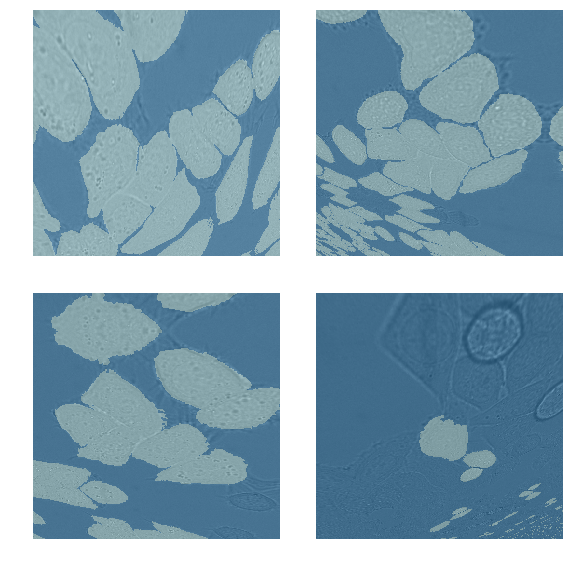

In [7]:
data.show_batch(2)

## UpDownNet

In [35]:
def conv(ci=512, co=256, k=1, s=1): return nn.Conv2d(ci, co, k, stride=s, padding=k//2)
def upsample(ci=256, co=256, k=2, s=2): 
    return nn.Sequential(nn.ConvTranspose2d(ci, co, k, stride=s), nn.ReLU(True), nn.BatchNorm2d(co))

def binary_dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [36]:
class UpDownNet(nn.Module):
    def __init__(self, backbone, pretrained=True):
        super().__init__()
        self.up = create_body(backbone, pretrained=pretrained)
        self.down = nn.Sequential(
            conv(), 
            upsample(),
            upsample(),
            upsample(),
            upsample(), 
            nn.ConvTranspose2d(256, 1, 2, stride=2))
        
    def forward(self, x):
        pred = self.down(self.up(x))
        return pred

In [37]:
backbone = models.resnet34
model = UpDownNet(backbone)
learn = Learner(data, 
                model, 
                opt_func=partial(optim.SGD, momentum=0.99), 
                metrics=[partial(accuracy_thresh, thresh=0.5), binary_dice],
                loss_func=partial(F.binary_cross_entropy_with_logits, pos_weight=weights[-1]))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


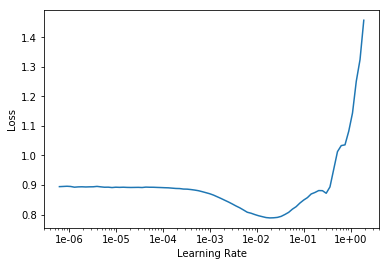

In [172]:
learn.lr_find()
learn.recorder.plot()

In [38]:
callbacks = [
    SaveModelCallback(learn, monitor='binary_dice', mode='max', name='updownnet'), 
    TerminateOnNaNCallback(), 
    GradientClipping(learn, clip=0.1),
    ReduceLROnPlateauCallback(learn, patience=30, min_delta=0.01)]
learn.callbacks.extend(callbacks)

In [40]:
# this is not the first run - first run was 500 epochs, at lr: 1e-2
learn.fit(50, 1e-02)

epoch,train_loss,valid_loss,accuracy_thresh,binary_dice,time
0,0.235118,0.166058,0.897823,0.881227,00:01
1,0.222425,0.165324,0.898060,0.881543,00:01
2,0.224858,0.162818,0.898540,0.881427,00:01
3,0.224904,0.161359,0.898552,0.880885,00:01
4,0.224484,0.159999,0.898518,0.880233,00:01
5,0.221275,0.159435,0.898785,0.880341,00:01
6,0.217387,0.158393,0.899231,0.880671,00:01
7,0.216658,0.157523,0.899204,0.880278,00:01
8,0.217978,0.157400,0.898098,0.878574,00:01
9,0.216718,0.157086,0.898079,0.878361,00:01


Better model found at epoch 0 with binary_dice value: 0.881227433681488.
Better model found at epoch 1 with binary_dice value: 0.8815433382987976.
Better model found at epoch 11 with binary_dice value: 0.8828447461128235.
Better model found at epoch 13 with binary_dice value: 0.884358286857605.
Better model found at epoch 14 with binary_dice value: 0.884698212146759.
Better model found at epoch 15 with binary_dice value: 0.8874855637550354.
Better model found at epoch 37 with binary_dice value: 0.8901775479316711.
Better model found at epoch 38 with binary_dice value: 0.8938384652137756.
Better model found at epoch 39 with binary_dice value: 0.8948501944541931.
Better model found at epoch 40 with binary_dice value: 0.8971272706985474.
Better model found at epoch 45 with binary_dice value: 0.8989624381065369.
Better model found at epoch 47 with binary_dice value: 0.900085985660553.
Better model found at epoch 48 with binary_dice value: 0.9004086256027222.


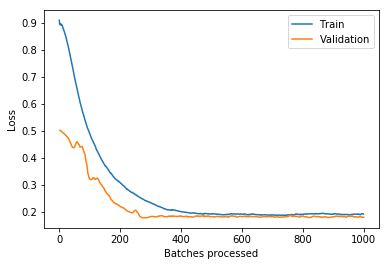

In [186]:
learn.recorder.plot_losses()  # loss for first run (epochs: 1000, lr: 1e-2)

In [41]:
x, y = data.train_ds[0]
x = x.data.unsqueeze(0).cuda()
y = y.data.cuda()
truth = Image(y)

In [42]:
pred = learn.pred_batch(batch=(x, y), reconstruct=True)[0]

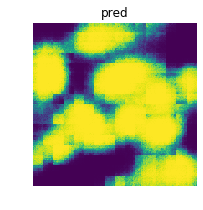

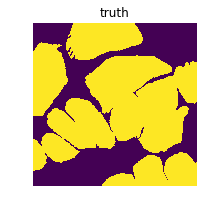

In [43]:
pred.show(title='pred'); truth.show(title='truth')

## FPN (single output)

In [8]:
def conv(ci=512, co=256, k=1, s=1): return nn.Conv2d(ci, co, k, stride=s, padding=k//2)
def upsample(ci=256, co=256, k=2, s=2): 
    return nn.Sequential(nn.ConvTranspose2d(ci, co, k, stride=s), nn.ReLU(True), nn.BatchNorm2d(co))

def binary_dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [9]:
def custom_freeze(learn, n=90):
    for g in learn.layer_groups[0][:n]:
        if not learn.train_bn or not isinstance(g, bn_types): requires_grad(g, False)
    for g in learn.layer_groups[0][n:]: requires_grad(g, True)
    learn.create_opt(defaults.lr)
    return learn

In [10]:
class FPN(nn.Module):
    def __init__(self, backbone, pretrained=True):
        super().__init__()
        self.backbone = create_body(backbone, pretrained=pretrained)
        self.hooks = hook_outputs(self.backbone[4:])
        self.conv = conv()
        self.ups = nn.ModuleList(upsample() for u in range(4))
        self.t_conv = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self, x):
        out = self.conv(self.backbone(x))
        maps = [o.stored for o in self.hooks][-2::-1]
        for i, u in enumerate(self.ups):
            try:
                c = conv(ci=maps[i].shape[1]).cuda()
            except:
                out = u(out)
                break
            out = u(out) + c(maps[i])
        return self.t_conv(out)
    
    def remove(self):
        self.hooks.remove()

In [11]:
backbone = models.resnet34
model = FPN(backbone).cuda()
learn = Learner(data, 
                model, 
                opt_func=partial(optim.SGD, momentum=0.99), 
                metrics=[partial(accuracy_thresh, thresh=0.5), binary_dice],
                loss_func=partial(F.binary_cross_entropy_with_logits, pos_weight=weights[-1]))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


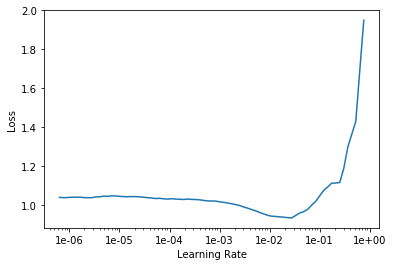

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
callbacks = [
    SaveModelCallback(learn, monitor='binary_dice', mode='max', name='fpn'), 
    TerminateOnNaNCallback(), 
    GradientClipping(learn, clip=0.1),
    ReduceLROnPlateauCallback(learn, patience=100, min_delta=0.01)]
learn.callbacks.extend(callbacks)

In [19]:
# this is not the first run - first run was 1000 epochs, at lr: 1e-2
learn.fit(50, 1e-2)

epoch,train_loss,valid_loss,accuracy_thresh,binary_dice,time
0,0.144448,0.110201,0.932468,0.921606,00:01
1,0.130994,0.108158,0.926208,0.910336,00:01
2,0.130109,0.108446,0.925385,0.908014,00:01
3,0.126204,0.104866,0.927784,0.911704,00:01
4,0.124056,0.107784,0.926109,0.909596,00:01
5,0.124266,0.110480,0.924500,0.906965,00:01
6,0.127345,0.109079,0.926552,0.911657,00:01
7,0.129254,0.109160,0.926926,0.911672,00:01
8,0.130611,0.125293,0.912273,0.890062,00:01
9,0.130219,0.126984,0.913174,0.890517,00:01


Better model found at epoch 0 with binary_dice value: 0.9216060638427734.
Better model found at epoch 37 with binary_dice value: 0.9228225946426392.
Better model found at epoch 45 with binary_dice value: 0.9257890582084656.


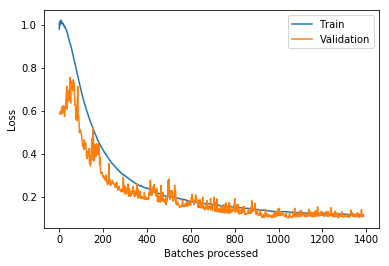

In [15]:
learn.recorder.plot_losses()  # loss for first run (epochs: 1000, lr: 1e-2)

In [32]:
x, y = data.train_ds[0]
x = x.data.unsqueeze(0).cuda()
y = y.data.cuda()
truth = Image(y)

In [33]:
pred = learn.pred_batch(batch=(x, y), reconstruct=True)[0]

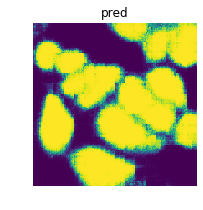

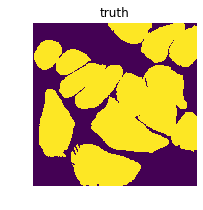

In [34]:
pred.show(title='pred'); truth.show(title='truth')

## COCO

In [3]:
path = Path('/home/sudosharma/projects/data/coco_tiny')
images, lbl_bbox = get_annotations(path/'train.json')
img2bbox = dict(zip(images, lbl_bbox))

In [4]:
get_y_fn = lambda o: img2bbox[o.name]

def get_data(bs=64, path=path, get_y=get_y_fn):
    """Create data loader with different batch sizes and size of image."""
    return (ObjectItemList.from_folder(path)
            .split_by_rand_pct()
            .label_from_func(get_y)
            .databunch(bs=bs, collate_fn=bb_pad_collate))

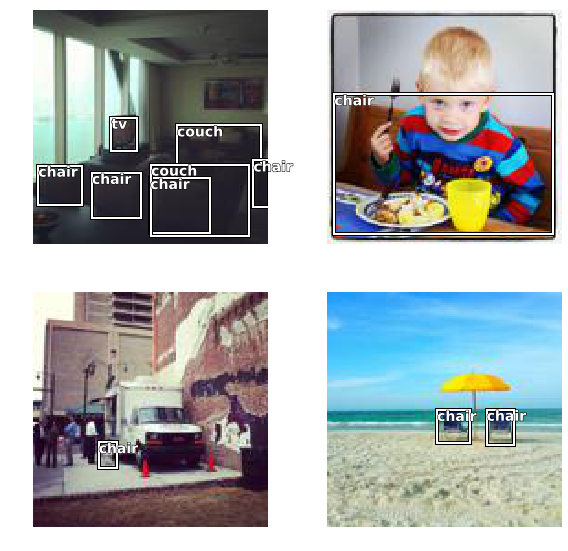

In [5]:
data = get_data()
data.show_batch(rows=2)

## RetinaNet

<b>TODO:</b>
1. figure out focal loss
- add classification subnet
- add regression subnet
- train on coco tiny
- train on coco
- see if you can match paper